<a href="https://colab.research.google.com/github/polliz9/atv1-dataframes/blob/main/atv2_und4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dados salvos em crypto_prices.csv


Acurácia do modelo: 0.50




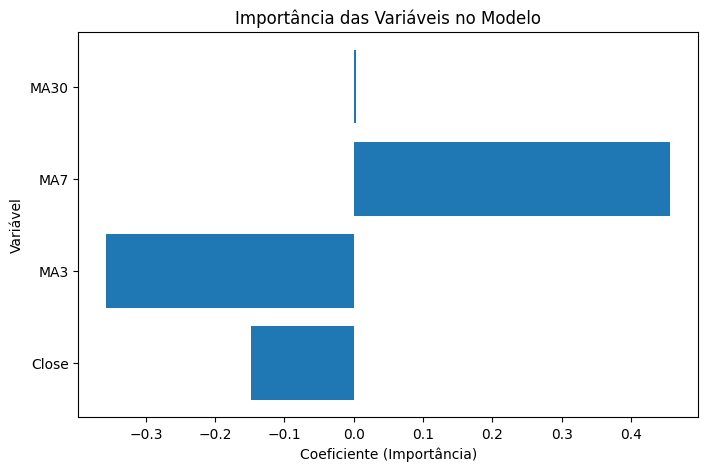

In [19]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Coletar dados históricos da API do CoinGecko
def fetch_crypto_data(crypto='bitcoin', days=365):
    url = f'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
    params = {'vs_currency': 'usd', 'days': days, 'interval': 'daily'}
    response = requests.get(url, params=params)
    data = response.json()

    # Converter para DataFrame
    prices = data['prices']
    dates = [datetime.utcfromtimestamp(p[0] / 1000).strftime('%Y-%m-%d') for p in prices]
    closing_prices = [p[1] for p in prices]

    df = pd.DataFrame({'Date': dates, 'Close': closing_prices})
    df.to_csv('crypto_prices.csv', index=False)
    print('Dados salvos em crypto_prices.csv\n\n')

    return df

# 2. Preparar os dados para o modelo
def prepare_data(df):
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    # Adicionar características adicionais (médias móveis)
    df['MA3'] = df['Close'].rolling(window=3).mean()
    df['MA7'] = df['Close'].rolling(window=7).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()

    df.dropna(inplace=True)
    return df

# 3. Treinar o modelo de classificação
def train_model(df):
    X = df[['Close', 'MA3', 'MA7', 'MA30']]
    y = df['Target']

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Treinar modelo de Regressão Logística
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # Avaliar o modelo
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Acurácia do modelo: {accuracy:.2f}\n\n')

    return model, X.columns

# 4. Visualizar a importância das variáveis
def plot_feature_importance(model, features):
    importance = model.coef_[0]
    plt.figure(figsize=(8, 5))
    plt.barh(features, importance)
    plt.xlabel('Coeficiente (Importância)')
    plt.ylabel('Variável')
    plt.title('Importância das Variáveis no Modelo')
    plt.show()

# Executar o pipeline
df = fetch_crypto_data()
df = prepare_data(df)
model, features = train_model(df)
plot_feature_importance(model, features)
